# **Day 5-7**：聚类与降维
  * 降维：`PCA`
  * 模型：`KMeans` `GMM` `SpectralClustering`
  * 实战：MNIST 手写数字聚类与可视化（KMeans 聚类，t-SNE/PCA 可视化，评估聚类效果）

MNIST 图片每个是 8x8 或 28x28 像素，展平后是 64 或 784 个特征！维度超高！

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits # sklearn 内置的 MNIST 数据集（简化版，8x8像素）
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA # PCA 降维
from sklearn.cluster import KMeans # KMeans 聚类算法
from sklearn.manifold import TSNE # t-SNE 可视化
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, silhouette_score # 无监督聚类评估指标

## 加载数据集

In [3]:
data = load_digits() 
X, y = data.data, data.target

In [4]:
print("数据形状:", X.shape)
print("标签形状:", y.shape)   
print("数据类型:", X.dtype)
print("标签示例:", y[:10])

数据形状: (1797, 64)
标签形状: (1797,)
数据类型: float64
标签示例: [0 1 2 3 4 5 6 7 8 9]


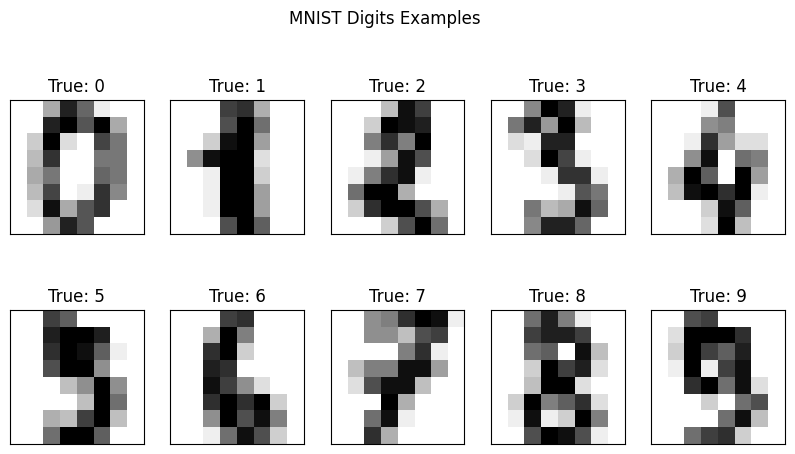

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(8, 8), cmap='binary', interpolation='nearest')
    ax.set_title(f'True: {y[i]}')
plt.suptitle("MNIST Digits Examples", y=1.02)
plt.show()

KMeans 算法是基于距离计算的。需要标准化。

## 数据预处理

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 
print("标准化后数据形状:", X_scaled.shape)
print("标准化后数据示例 (前10个特征):", X_scaled[0, :10])

标准化后数据形状: (1797, 64)
标准化后数据示例 (前10个特征): [ 0.         -0.33501649 -0.04308102  0.27407152 -0.66447751 -0.84412939
 -0.40972392 -0.12502292 -0.05907756 -0.62400926]


In [7]:
n_components_pca = 30   

pca = PCA(n_components=n_components_pca, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA 降维到 {n_components_pca} 维后数据形状:", X_pca.shape)

PCA 降维到 30 维后数据形状: (1797, 30)


In [8]:
explained_variance_ratio = pca.explained_variance_ratio_.sum() #每个主成分的方差贡献率
print(f"PCA 解释的总方差比例: {explained_variance_ratio:.4f}")

PCA 解释的总方差比例: 0.8932


解释方差是指PCA中每个主成分解释的原始数据方差的比例。它表示每个主成分对原始数据的贡献度。

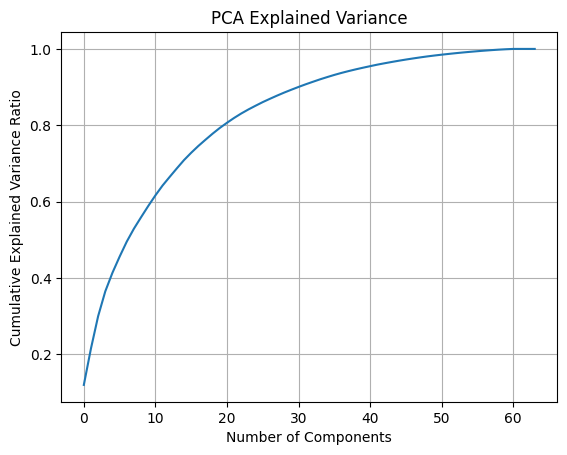

In [9]:
pca_full = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

## 聚类

In [10]:
n_clusters_kmeans = 10

kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42, n_init=10)
kmeans.fit(X_pca)

clusters = kmeans.labels_

centroids = kmeans.cluster_centers_

print("聚类完成。")
print("前 10 个样本的聚类标签:", clusters[:10])
print("聚类中心点形状:", centroids.shape) # 应该显示 (10, n_components_pca)

聚类完成。
前 10 个样本的聚类标签: [4 0 0 1 3 1 7 5 1 1]
聚类中心点形状: (10, 30)


Kmeans参数：
- tol（tolerance） 类型：float 默认值：1e-4 描述：收敛容差，即当簇中心的变化小于该值时，算法停止迭代
- algorithm 类型：{'auto', 'full', 'elkan'} 默认值：'auto'
  - 'auto'：自动选择算法。
  - 'full'：使用经典 k-means 算法。
  - 'elkan'：使用 Elkan 算法，通常更快但可能不如经典算法稳定。
-  n_init: 运行 KMeans 算法 n_init 次，每次随机初始化，最后选择最佳结果 (防止陷入局部最优)

属性：
- labels_：每个样本所属的簇
- cluster_centers_：簇中心
- inertia_：簇内误差平方和，越小簇内误差越小，越聚拢

## 评估&可视化

评估聚类效果常用metircs:
- Homogeneity (同质性): 每个聚类只包含单个类别的样本。高 Homogeneity 意味着聚类很“纯”。
- Completeness (完整性): 属于同一个类别的样本都被分到同一个聚类中。高 Completeness 意味着同一个类别的样本没有被“分散”。
- V-measure (V 度量): Homogeneity 和 Completeness 的调和平均，综合反映聚类效果。
- Adjusted Rand Index (ARI): 衡量两个聚类划分结果（你的聚类结果和真实标签）的相似度，考虑了随机因素。ARI 的值在 -1 到 1 之间，1 表示完美匹配，0 表示随机聚类。
- Silhouette Score (轮廓系数): 注意！ **Silhouette Score 是内部评估指标，它不使用真实标签 y**。它衡量每个样本与其自身聚类内的点有多接近，以及与最近的其他聚类内的点有多远。 Silhouette Score 的值在 -1 到 1 之间，越接近 1 越好。如果**没有真实标签 y**，你会主要依赖 Silhouette Score 或 Elbow Method 等方法来评估和选择 K 值。在这个项目里，我们有 y，所以主要使用前面几个基于标签的指标。

In [11]:
homogeneity = homogeneity_score(y, clusters)
completeness = completeness_score(y, clusters)
v_measure = v_measure_score(y, clusters)
ari = adjusted_rand_score(y, clusters)

In [12]:
print(f"Homogeneity: {homogeneity:.4f}")
print(f"Completeness: {completeness:.4f}")
print(f"V-measure: {v_measure:.4f}")
print(f"Adjusted Rand Index: {ari:.4f}")

Homogeneity: 0.6083
Completeness: 0.6559
V-measure: 0.6312
Adjusted Rand Index: 0.4764


Kmeans是线性、基于欧氏距离的简单聚类算法，面对手写数字这种非线性、分布复杂的数据，效果有限。

评估指标给了我们量化的分数，但把数据点画出来看看，直观感受一下聚类的效果也非常重要！由于数据是高维的 (64维原始或 30维 PCA)，我们需要进一步降维到 2D 或 3D 才能画图。最常用的方法是 PCA (降到 2 或 3 维) 和 t-SNE。

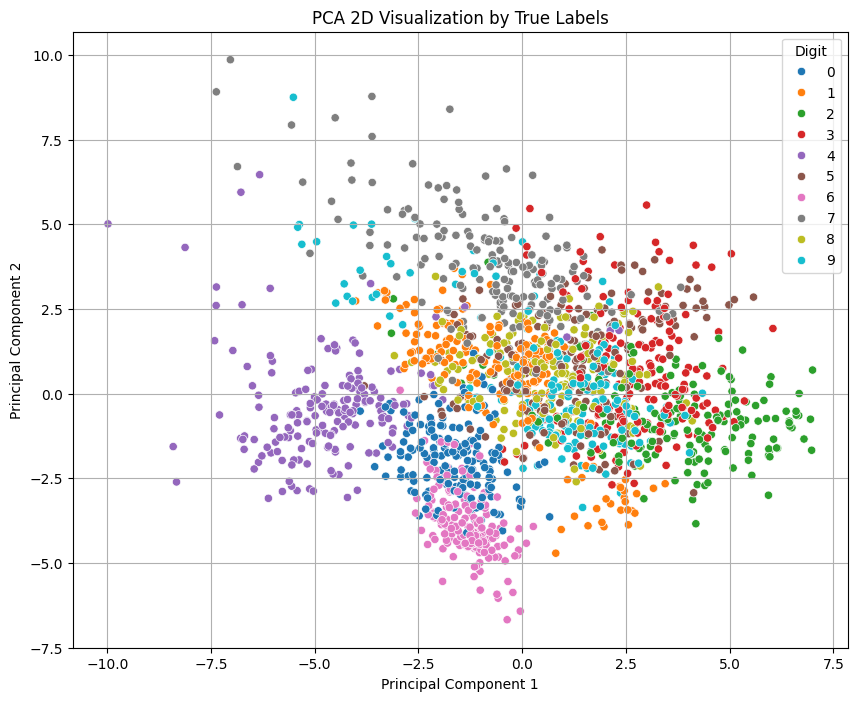

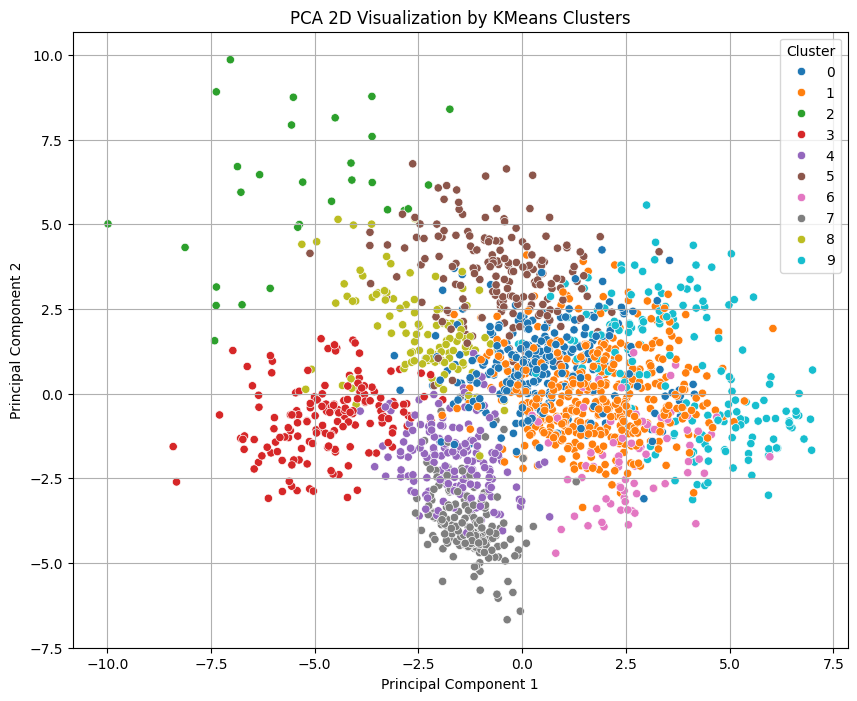

In [13]:
# 将数据进一步降维到 2 维用于可视化
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled) # 注意这里是对标准化后的原始数据进行 PCA 降维到 2 维

# 可视化：按真实标签上色
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], hue=y, palette='tab10', legend='full')
plt.title('PCA 2D Visualization by True Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Digit', loc='best')
plt.grid(True)
plt.show()

# 可视化：按 KMeans 聚类结果上色
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], hue=clusters, palette='tab10', legend='full')
plt.title('PCA 2D Visualization by KMeans Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', loc='best')
plt.grid(True)
plt.show()

可以发现聚类和真实的标签完全对不上，这是无监督算法的必然结果。这里降到2维，导致聚类效果不好。

t-SNE（t-Distributed Stochastic Neighbor Embedding） 是一种非线性降维方法，它更擅长保留数据点之间的局部关系。在可视化聚类结果时，t-SNE 通常能比 PCA 更好地将不同的聚类/类别分开，使簇的边界更清晰。但 t-SNE 计算量较大，通常在少量样本或经过 PCA 降维后的数据上进行。

正在计算 t-SNE...
t-SNE 计算完成。
t-SNE 降维到 2 维后数据形状: (1797, 2)


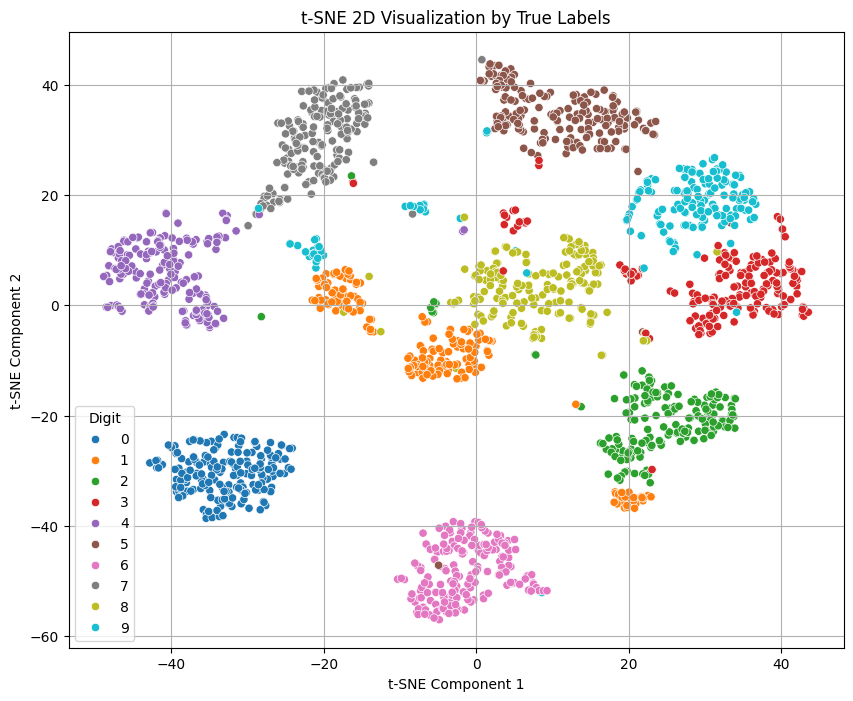

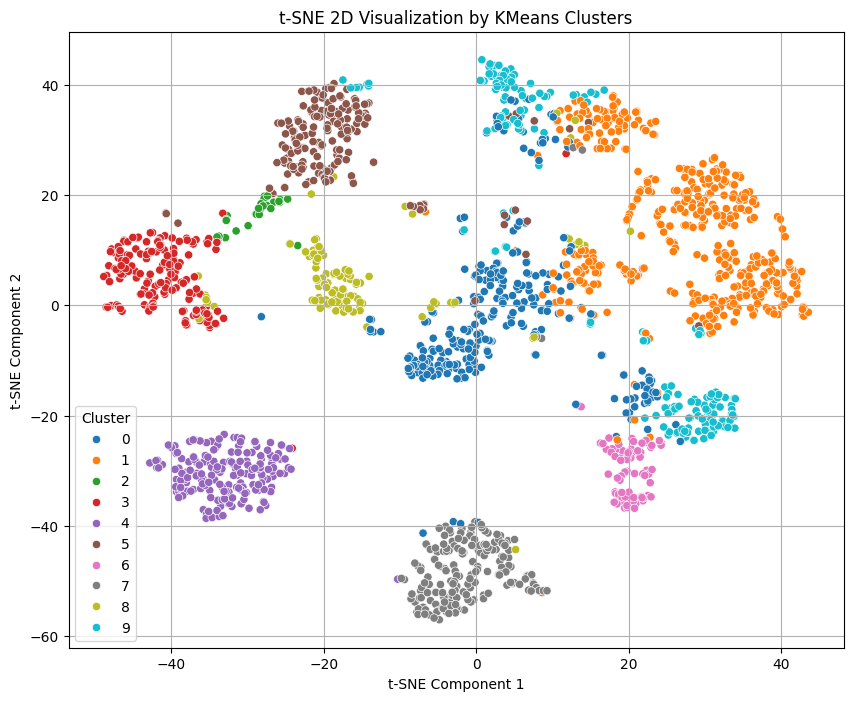

In [14]:
# 由于 t-SNE 计算量大，通常在样本较少或已经降维的数据上运行。
# 这里我们直接在 PCA 降维到 30 维的数据的 (X_pca) 上运行 t-SNE

# 警告：t-SNE 计算可能需要一些时间！耐心等待... ☕️
print("正在计算 t-SNE...")

# n_components=2 表示降到 2 维
# init='pca' 使用 PCA 结果初始化，有助于稳定和加速
# learning_rate='auto' 或一个值 (e.g., 200)
# n_iter=300 或更多，迭代次数，影响收敛
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_pca) # 在 PCA 降维后的数据上应用 t-SNE
print("t-SNE 计算完成。")
print("t-SNE 降维到 2 维后数据形状:", X_tsne.shape)

# 可视化：按真实标签上色
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='tab10', legend='full')
plt.title('t-SNE 2D Visualization by True Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Digit', loc='best')
plt.grid(True)
plt.show()

# 可视化：按 KMeans 聚类结果上色
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=clusters, palette='tab10', legend='full')
plt.title('t-SNE 2D Visualization by KMeans Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster', loc='best')
plt.grid(True)
plt.show()

## 其他聚类模型： 
 
Kmeans假设同类数据在欧几里得空间中成球状分布。
**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**
- 原理： DBSCAN 是基于密度的聚类算法。它寻找数据点密集连接的区域，并将这些区域划分为簇。它不假设簇是球形的，而且能有效地识别出噪声点（不属于任何簇的点）。
- 核心概念：
    - ε (epsilon): 一个距离阈值。以某个点为圆心，画一个半径为 ε 的圆，看看里面有多少其他点。
    - MinPts: 一个点数阈值。如果一个点的 ε 邻域内点数大于等于 MinPts，它就是核心点 (Core Point)。
    - 可达性 (Reachability): 如果点 B 在点 A 的 ε 邻域内，并且点 A 是核心点，那么 B 从 A 是直接可达的。如果一系列点都是可达的，那么它们就属于同一个簇。
    - 边界点 (Border Point): 在某个核心点的 ε 邻域内，但它自己不是核心点。边界点属于核心点所在的簇。
    - 噪声点 (Noise Point): 既不是核心点也不是边界点。
- 什么时候用： 数据集有明显的不规则形状簇，或者包含需要被忽略的噪声点。
- 缺点： 对于密度差异很大的簇效果不好，对 ε 和 MinPts 参数比较敏感。   

**Agglomerative Clustering (层次聚类 - 凝聚型)**
- 原理： 这是一种层次的聚类方法。凝聚型是从下往上构建层次结构。开始时，每个数据点都是一个独立的簇。然后，算法迭代地将最相似的两个簇合并，直到满足停止条件（比如达到指定的簇数量 K，或者簇之间的相似度低于某个阈值）。这个合并过程可以可视化为一棵树状图 (Dendrogram)。
- 核心概念：
    - 相似度/距离度量： 如何计算两个数据点之间的距离（如欧几里得距离）。
    - 连接方式 (Linkage): 如何计算两个簇之间的距离（因为簇里可能包含多个点）。常见的有：
        - Single Linkage: 两个簇之间距离最近的两个点之间的距离。容易形成“链”状簇。
        - Complete Linkage: 两个簇之间距离最远的两个点之间的距离。倾向于形成球状簇。
        - Average Linkage: 两个簇之间所有点对的平均距离。
        - Ward Linkage: 合并两个簇后，总的簇内平方和增加的最小化。倾向于形成大小相似的簇。
- 什么时候用： 你不确定最佳的簇数量 K，或者你对数据点之间的层次关系感兴趣。
- 缺点： 计算量通常比 KMeans 大（O(n^2) 或 O(n^3)），内存消耗也可能更大；对异常值敏感（特别是 Single Linkage）。

**Gaussian Mixture Models (GMM)**
- 原理： GMM 是一种概率模型，它假设整个数据集是由 K 个不同的高斯分布（正态分布）“混合”生成的。每个高斯分布代表一个簇。算法的目标是通过期望最大化 -(Expectation-Maximization, EM) 算法，找到每个高斯分布的参数（均值、协方差矩阵）以及每个分布在混合中所占的权重。
- 核心概念：
    - 高斯分布： 每个簇的数据点被认为服从一个多维正态分布，由其均值和协方差矩阵定义（协方差矩阵决定了分布的形状和方向，不像 KMeans 隐含地假设是球形的）。
    - 混合权重： 每个高斯分布在总体数据中所占的比例。
    - EM 算法： 迭代过程。E 步骤：根据当前的高斯分布参数，计算每个数据点属于每个簇的概率（软分配）。M 步骤：根据数据点属于各个簇的概率，重新估计每个高斯分布的参数和混合权重。重复直到收敛。
- 什么时候用： 你认为不同的簇是由不同的概率分布生成的，或者你需要数据点属于多个簇的概率信息，或者簇不是简单的球形。
- 缺点： 需要预先指定 K；算法可能收敛到局部最优；对初始值敏感；计算量比 KMeans 大；对维度数量比较敏感（协方差矩阵在高维时参数很多）。

**Spectral Clustering (谱聚类)**
- 原理： 谱聚类是一种基于图论的聚类方法。它首先将数据点表示为一个图，图中的节点是数据点，边代表数据点之间的相似度（边权重越大越相似）。然后，它利用图的拉普拉斯矩阵进行特征分解（计算特征向量），将数据点投影到由特征向量构成的低维空间。最后，在这个低维空间里，使用 KMeans（或其他简单的聚类算法）进行聚类。
- 核心概念：
    - 相似度图 (Similarity Graph): 根据数据点之间的相似度构建的图（如 ε-邻近图、K-邻近图、全连接图加高斯相似度）。
    - 拉普拉斯矩阵 (Laplacian Matrix): 从相似度图导出的一个矩阵，其特征向量包含了图的重要结构信息。
    - 嵌入 (Embedding): 将数据点根据拉普拉斯矩阵的特征向量投影到低维空间。
- 什么时候用： 数据集的簇形状复杂，传统基于距离的方法难以区分，或者你认为数据点之间存在更抽象的连接关系。
- 缺点： 需要预先指定 K（用于最后一步的 KMeans）；计算量大，特别是构建相似度图和进行特征分解的阶段；对相似度图的构建（如何定义相似度和邻域）很敏感；内存消耗较大。

试试GMM（高斯混合模型）：允许软聚类，能拟合更复杂的分布。

In [15]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10, random_state=42, n_init=10)
gmm_labels = gmm.fit_predict(X_pca)

print("GMM Homogeneity:", homogeneity_score(y, gmm_labels))
print("GMM Completeness:", completeness_score(y, gmm_labels))
print("GMM V-measure:", v_measure_score(y, gmm_labels))
print("GMM ARI:", adjusted_rand_score(y, gmm_labels))

GMM Homogeneity: 0.7025194035335947
GMM Completeness: 0.7519452023697514
GMM V-measure: 0.7263925061011078
GMM ARI: 0.5875601030748054


再试试谱聚类

In [17]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', random_state=42)
sc_labels = sc.fit_predict(X_pca)

print("GMM Homogeneity:", homogeneity_score(y, sc_labels))
print("GMM Completeness:", completeness_score(y, sc_labels))
print("GMM V-measure:", v_measure_score(y, sc_labels))
print("GMM ARI:", adjusted_rand_score(y, sc_labels))

GMM Homogeneity: 0.7934250914255511
GMM Completeness: 0.8422614528565151
GMM V-measure: 0.8171142234714841
GMM ARI: 0.6919196612688875


## 无监督学习

**降维 (Dimensionality Reduction)** 📉➡️✨
*   **目的：** 减少数据的特征数量，同时尽量保留数据中的重要信息或结构。
*   **为什么需要：**
    *   数据的诅咒 (Curse of Dimensionality): 高维数据会导致计算量剧增、模型更容易过拟合、可视化困难等问题。
    *   去除噪声： 有些低方差的维度可能是噪声。
    *   特征提取： 创建新的、更简洁、可能更有意义的特征组合。
    *   可视化： 将数据降到 2D 或 3D 才能画图展示。
*   **常用方法：**
    *   **PCA (Principal Component Analysis):** 主成分分析。线性降维，寻找数据方差最大的方向，将数据投影到这些方向上。保留数据的全局线性结构。
    *   **t-SNE (t-Distributed Stochastic Neighbor Embedding):** t-分布随机邻域嵌入。非线性降维，主要用于**可视化**。它试图保留数据点之间的局部邻近关系，在高维空间中相似的点在低维空间中仍然相似，反之亦然。常用于可视化聚类结果或高维数据分布。
    *   **UMAP (Uniform Manifold Approximation and Projection):** 均匀流形逼近与投影。也是非线性降维，类似于 t-SNE，但通常更快，并且在保留局部结构的同时，也能更好地保留数据的全局结构。
    *   **Autoencoders (自编码器):** 一种神经网络结构，训练模型将输入压缩到低维**编码**层，再从编码层重建原始输入。编码层就是数据的低维表示。可以学习复杂的非线性降维。

**关联规则挖掘 (Association Rule Mining)** 🛒🍺🍼
*   **目的：** 发现数据集中不同项目之间的有趣关系或关联性。最经典的应用是“购物篮分析”(Market Basket Analysis)。
*   **问题示例：** 顾客购买了啤酒和尿布，是否也经常购买纸巾？
*   **常用算法：**
    *   **Apriori 算法：** 发现频繁项集（在数据集中一起出现的频率很高的项目组合），然后基于频繁项集生成关联规则。
*   **核心概念：**
    *   **支持度 (Support):** 某个项集在数据集中出现的频率。
    *   **置信度 (Confidence):** 规则 `A -> B` 的置信度是，在购买了 A 的交易中，也购买了 B 的比例。
    *   **提升度 (Lift):** 规则 `A -> B` 的提升度是，在购买了 A 的情况下购买 B 的可能性，除以在没有购买 A 的情况下购买 B 的可能性。大于 1 表示 A 和 B 一起出现的概率高于独立出现的概率。

**异常检测 (Anomaly Detection) / 离群点检测 (Outlier Detection)** 🚨🧐
*   **目的：** 识别数据集中那些与大多数数据点显著不同的样本，这些点可能是错误数据、欺诈行为、系统故障或新现象。
*   **为什么需要：** 数据清洗、欺诈检测、入侵检测、故障诊断等。
*   **常用方法：**
    *   **基于距离的方法：** 计算数据点与其他点的距离，距离远的点可能是异常点（如 k-近邻距离、局部离群因子 LOF）。
    *   **基于密度的方法：** 数据点周围密度较低的可能是异常点（如 **DBSCAN** 也可以识别噪声点，**LOF** 也属于此类）。
    *   **基于模型的方法：** 训练一个模型来描述“正常”数据的分布，然后将偏离这个模型的点视为异常（如 **One-Class SVM**, **Isolation Forest**, 基于自编码器的方法）。

**密度估计 (Density Estimation)** 📈🏞️
*   **目的：** 估计数据在样本空间的概率密度函数。简单来说，就是找出数据在哪里比较“密集”，在哪里比较“稀疏”。
*   **为什么需要：** 理解数据分布、异常检测（密度低的区域是异常）、数据生成（学习数据的分布后可以生成类似的新数据）。
*   **常用方法：**
    *   **直方图 (Histogram):** 最简单的密度估计。
    *   **核密度估计 (Kernel Density Estimation - KDE):** 用平滑的核函数来估计概率密度，得到一个连续的密度曲面。
    *   **高斯混合模型 (GMM):** GMM 不仅可以用于聚类，也可以作为一种强大的密度估计方法，它将复杂的数据分布建模为多个高斯分布的混合。

**数据生成 (Data Generation) / 表示学习 (Representation Learning)** 🎨🖼️💻
*   **目的：** 学习数据的内在结构，并能够生成新的、与原始数据相似的样本，或者学习到数据的更有意义、更紧凑的表示（Representation）。
*   **常用方法：**
    *   **Generative Adversarial Networks (GANs):** 生成对抗网络。由一个生成器和一个判别器组成，互相博弈，最终生成器能生成逼真的新数据。
    *   **Variational Autoencoders (VAEs):** 变分自编码器。一种生成模型，可以学习数据的潜在空间，并从这个潜在空间采样生成新数据。
    *   **自编码器 (Autoencoders):** 除了降维，自编码器的编码层学习到的“编码”就是数据的低维表示。

**特征学习 (Feature Learning) / 特征提取 (Feature Extraction)** 🔍🧠
*   **目的：** 自动从原始数据中学习或提取更有用、更有信息量、更抽象的特征，而不是手动进行特征工程。
*   **常用方法：**
    *   **PCA:** 提取原始特征的线性组合作为新特征（主成分）。
    *   **Autoencoders:** 编码层的输出就是学习到的低维特征表示。
    *   **深度学习模型 (特别是无监督预训练):** 在大规模无标签数据上训练一个深度学习模型（如卷积神经网络 CNN 用于图像，Transformer 用于文本），模型的中间层学到的激活值可以作为后续任务（如分类、聚类）的特征。